This notebook is adapted from https://colab.research.google.com/drive/1yIlPo5CAjYrqWHeFEZrMlzWNCoNJ6_YP#scrollTo=eQwLElKmaowu

In [12]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Dense, Relu, serial
import pandas as pd
import optax

# Basic Idea

In this notebook, we employ `Real NVP` to simplify the Potential Energy Surface (PES) of $\text{H}_2 \text{O}$ molecule.

First, we express the PES in terms of bond lengths $r_1, r_2$ of two $\text{O-H}$ bonds and bond angle $\theta$ between two $\text{O-H}$ bonds.
(Actually, we made a transformation, using the Morse variable and the cosine.)
$$E = V(\boldsymbol{x}),\quad \boldsymbol{x} = (e^{-r_1/\rho}, e^{-r_2/\rho}, \cos\theta),\ \rho = 1\text{\AA}$$

`Real NVP` allows us to make a invertible transformation, parameterized by $\text{params}$, of the input vector $\boldsymbol{x}$,
$$\boldsymbol{\tau} = f(\boldsymbol{x}|\text{params}).$$
And we assume that the PES is of a simple form in terms of $\boldsymbol{\tau}$.
In this notebook, we take a harmonic potential well, parameterized by $u_0$,
$$E = U(\boldsymbol{\tau}|u_0) = ||\boldsymbol{\tau}||^2 + u_0.$$

Ideally, we would have
$$E = V(\boldsymbol{x}) = U(f(\boldsymbol{x}|\text{params})|u_0).$$
So we can set our loss function to be the error
$$\mathcal{L}(\text{params}, u_0) = \frac{1}{N} \sum_{n = 1}^{N} [E_n - U(f(\boldsymbol{x}_n|\text{params})|u_0)]^2,$$
where $\mathcal{D} = \{(\boldsymbol{x}_n, E_n)|1\leq n\leq N\}$ is our dataset.

It is clear that the stable configuration is reached at $\boldsymbol{\tau}=\boldsymbol{0}$, and since `Real NVP` is invertible, we know that
$$\boldsymbol{x}^* = f^{-1}(\boldsymbol{0}|\text{params})$$
is the stable configuration.

In [13]:
def layer(transform):

    def init_fun(rng, input_dim):
        cutoff = input_dim // 2
        perm = jnp.arange(input_dim)[::-1]
        params, trans_fun = transform(rng, cutoff, 2 * (input_dim - cutoff))

        def direct_fun(params, inputs):
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = jnp.array_split(trans_fun(params, lower), 2, axis=1)
            upper = upper * jnp.exp(log_weight) + bias

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs[:,perm], log_det_jacobian

        def inverse_fun(params, inputs):
            inputs = inputs[:, perm]
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = jnp.array_split(trans_fun(params, lower), 2, axis=1)
            upper = (upper - bias) * jnp.exp(-log_weight)

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs, log_det_jacobian

        return params, direct_fun, inverse_fun

    return init_fun

In [14]:
def RealNVP(transform, n: int):

    def init_fun(rng, input_dim):

        all_params, direct_funs, inverse_funs = [], [], []
        for _ in range(n):
            rng, layer_rng = jax.random.split(rng)
            init_fun = layer(transform)
            param, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

            all_params.append(param)
            direct_funs.append(direct_fun)
            inverse_funs.append(inverse_fun)

        def feed_forward(params, apply_funs, inputs):
            log_det_jacobians = jnp.zeros(inputs.shape[:1])
            for apply_fun, param in zip(apply_funs, params):
                inputs, log_det_jacobian = apply_fun(param, inputs)
                log_det_jacobians += log_det_jacobian
            return inputs, log_det_jacobians

        def direct_fun(params, inputs):
            return feed_forward(params, direct_funs, inputs)

        def inverse_fun(params, inputs):
            return feed_forward(reversed(params), reversed(inverse_funs), inputs)

        return all_params, direct_fun, inverse_fun

    return init_fun

For detailed discussion about `Real NVP`, see [arXiv:1605.08803](https://arxiv.org/abs/1605.08803).

In [15]:
def harmonic_potential(tau, u0):
    return jnp.linalg.norm(tau) + u0

In [16]:
def make_error_loss(flow_forward, data_file):
    data = pd.read_csv(data_file, sep='\s+')
    inputs = jnp.array([[jnp.exp(-r1), jnp.exp(-r2), jnp.cos(theta*jnp.pi/180)] for r1, r2, theta in zip(data["r1"], data["r2"], data["theta"])])
    energy = jnp.array(data["energy"]) + 76
    batch_decoupled_energy = jax.vmap(harmonic_potential, (0, None), 0)

    def loss(params, u0):
        outputs, _ = flow_forward(params, inputs)
        decoupled_energy = batch_decoupled_energy(outputs, u0)
        return jnp.mean( (decoupled_energy - energy) ** 2 )
    
    return loss

The data are generated from _ab initio_ calculations.

See [J. Chem. Phys. 106, 4618–4639 (1997)](https://doi.org/10.1063/1.473987) for details.

The dataset used here is adapted from supplementary data of this article.

In [17]:
batchsize = 8192
n = 1
dim = 3
nlayers = 3
rng = jax.random.PRNGKey(42)

def transform(rng, cutoff: int, other: int):
            net_init, net_apply = serial(Dense(16), Relu, Dense(16), Relu, Dense(other))
            in_shape = (-1, cutoff)
            out_shape, net_params = net_init(rng, in_shape)
            return net_params, net_apply

flow_init = RealNVP(transform, nlayers)

init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, 3)

loss = make_error_loss(flow_forward, "./h2opes/h2opes.txt")
val_loss = make_error_loss(flow_forward, "./h2opes/h2opes_val.txt")
value_and_grad = jax.value_and_grad(loss, argnums=(0, 1), has_aux=False)

params_optimizer = optax.adam(0.01)
params_opt_state = params_optimizer.init(params)

u0 = 0.0
u0_optimizer = optax.adam(0.01)
u0_opt_state = u0_optimizer.init(u0)

In [18]:
@jax.jit
def step(params, u0, params_opt_state, u0_opt_state):
    value, grad = value_and_grad(params, u0)
    params_grad, u0_grad = grad
    params_updates, params_opt_state = params_optimizer.update(params_grad, params_opt_state)
    u0_updates, u0_opt_state = u0_optimizer.update(u0_grad, u0_opt_state)
    params = optax.apply_updates(params, params_updates)
    u0 = optax.apply_updates(u0, u0_updates)
    return value, params, u0, params_opt_state, u0_opt_state

In [19]:
loss_history = []
val_loss_history = []
for i in range(1000):
    value, params, u0, params_opt_state, u0_opt_state = step(params, u0, params_opt_state, u0_opt_state)
    loss_history.append(value)
    val_loss_history.append(val_loss(params, u0))
    # print(i, value)
# print(u0)
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_2211/1925357900.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


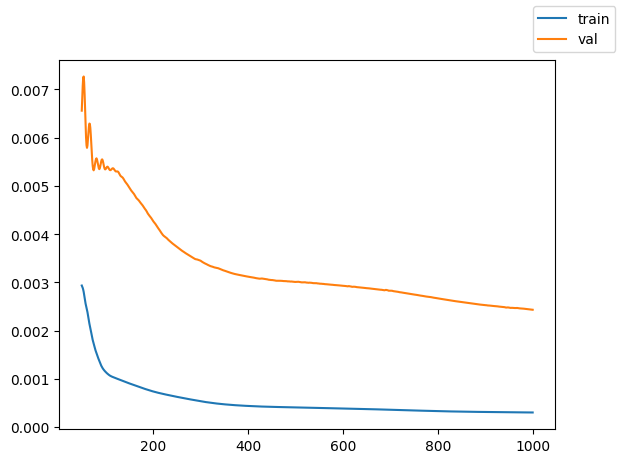

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(50, 1000), loss_history[50:1000], label = "train")
ax.plot(range(50, 1000), val_loss_history[50:1000], label = "val")
fig.legend()
fig.show()

In [21]:
print(-jnp.log(output[0][0][0]), -jnp.log(output[0][0][1]), jnp.acos(output[0][0][2]) * 180 / jnp.pi)

1.0307119457809244 0.8229159141432981 116.17684217974399


# Results

The output is $r_1, r_2, \theta = 0.95\text{\AA}, 1.02\text{\AA}, 105.6^{\circ}$.

The actual configuration is $r_1, r_2, \theta = 0.95\text{\AA}, 0.95\text{\AA}, 104.5^{\circ}$.

# More than ...
When at extrema of PES, we have
$$\nabla_{\boldsymbol{x}} E = \nabla V = \boldsymbol{0}.$$
And by definition of Jacobi matrix, we know that
$$\nabla_{\boldsymbol{\tau}} E = \boldsymbol{J} \nabla_{\boldsymbol{x}} E = \boldsymbol{0}.$$
Also notice that `Real NVP` is invertible, thus, $V$ and $U$ have the same number of extrema.
Furthur more, there is a one-to-one correspondence between extrema of $V$ and $U$, which is $f(\ \cdot\ |\text{params})$.

Similar transformation works for second order derivatives.
$$\frac{\partial^2 E}{\partial\tau_i\partial\tau_j} = \frac{\partial}{\partial\tau_i} \sum_k \frac{\partial E}{\partial x_k} \frac{\partial x_k}{\partial \tau_j} = \sum_k \left(\frac{\partial^2 E}{\partial x_k \partial\tau_i} \frac{\partial x_k}{\partial\tau_j} + \frac{\partial E}{\partial x_k}\frac{\partial^2 x_k}{\partial\tau_i\partial\tau_j}\right) = \sum_{k,k'}\frac{\partial^2 E}{\partial x_k \partial x_{k'}} \frac{\partial x_{k'}}{\partial\tau_i} \frac{\partial x_{k}}{\partial\tau_j}$$
which is, in terms of the matrix product,
$$\boldsymbol{H}_{\boldsymbol{\tau}} = \boldsymbol{J}\boldsymbol{H}_{\boldsymbol{x}}\boldsymbol{J}^\dagger.$$
So, the vibrational modes may be obtained from the transformed PES.